### Define Circuit

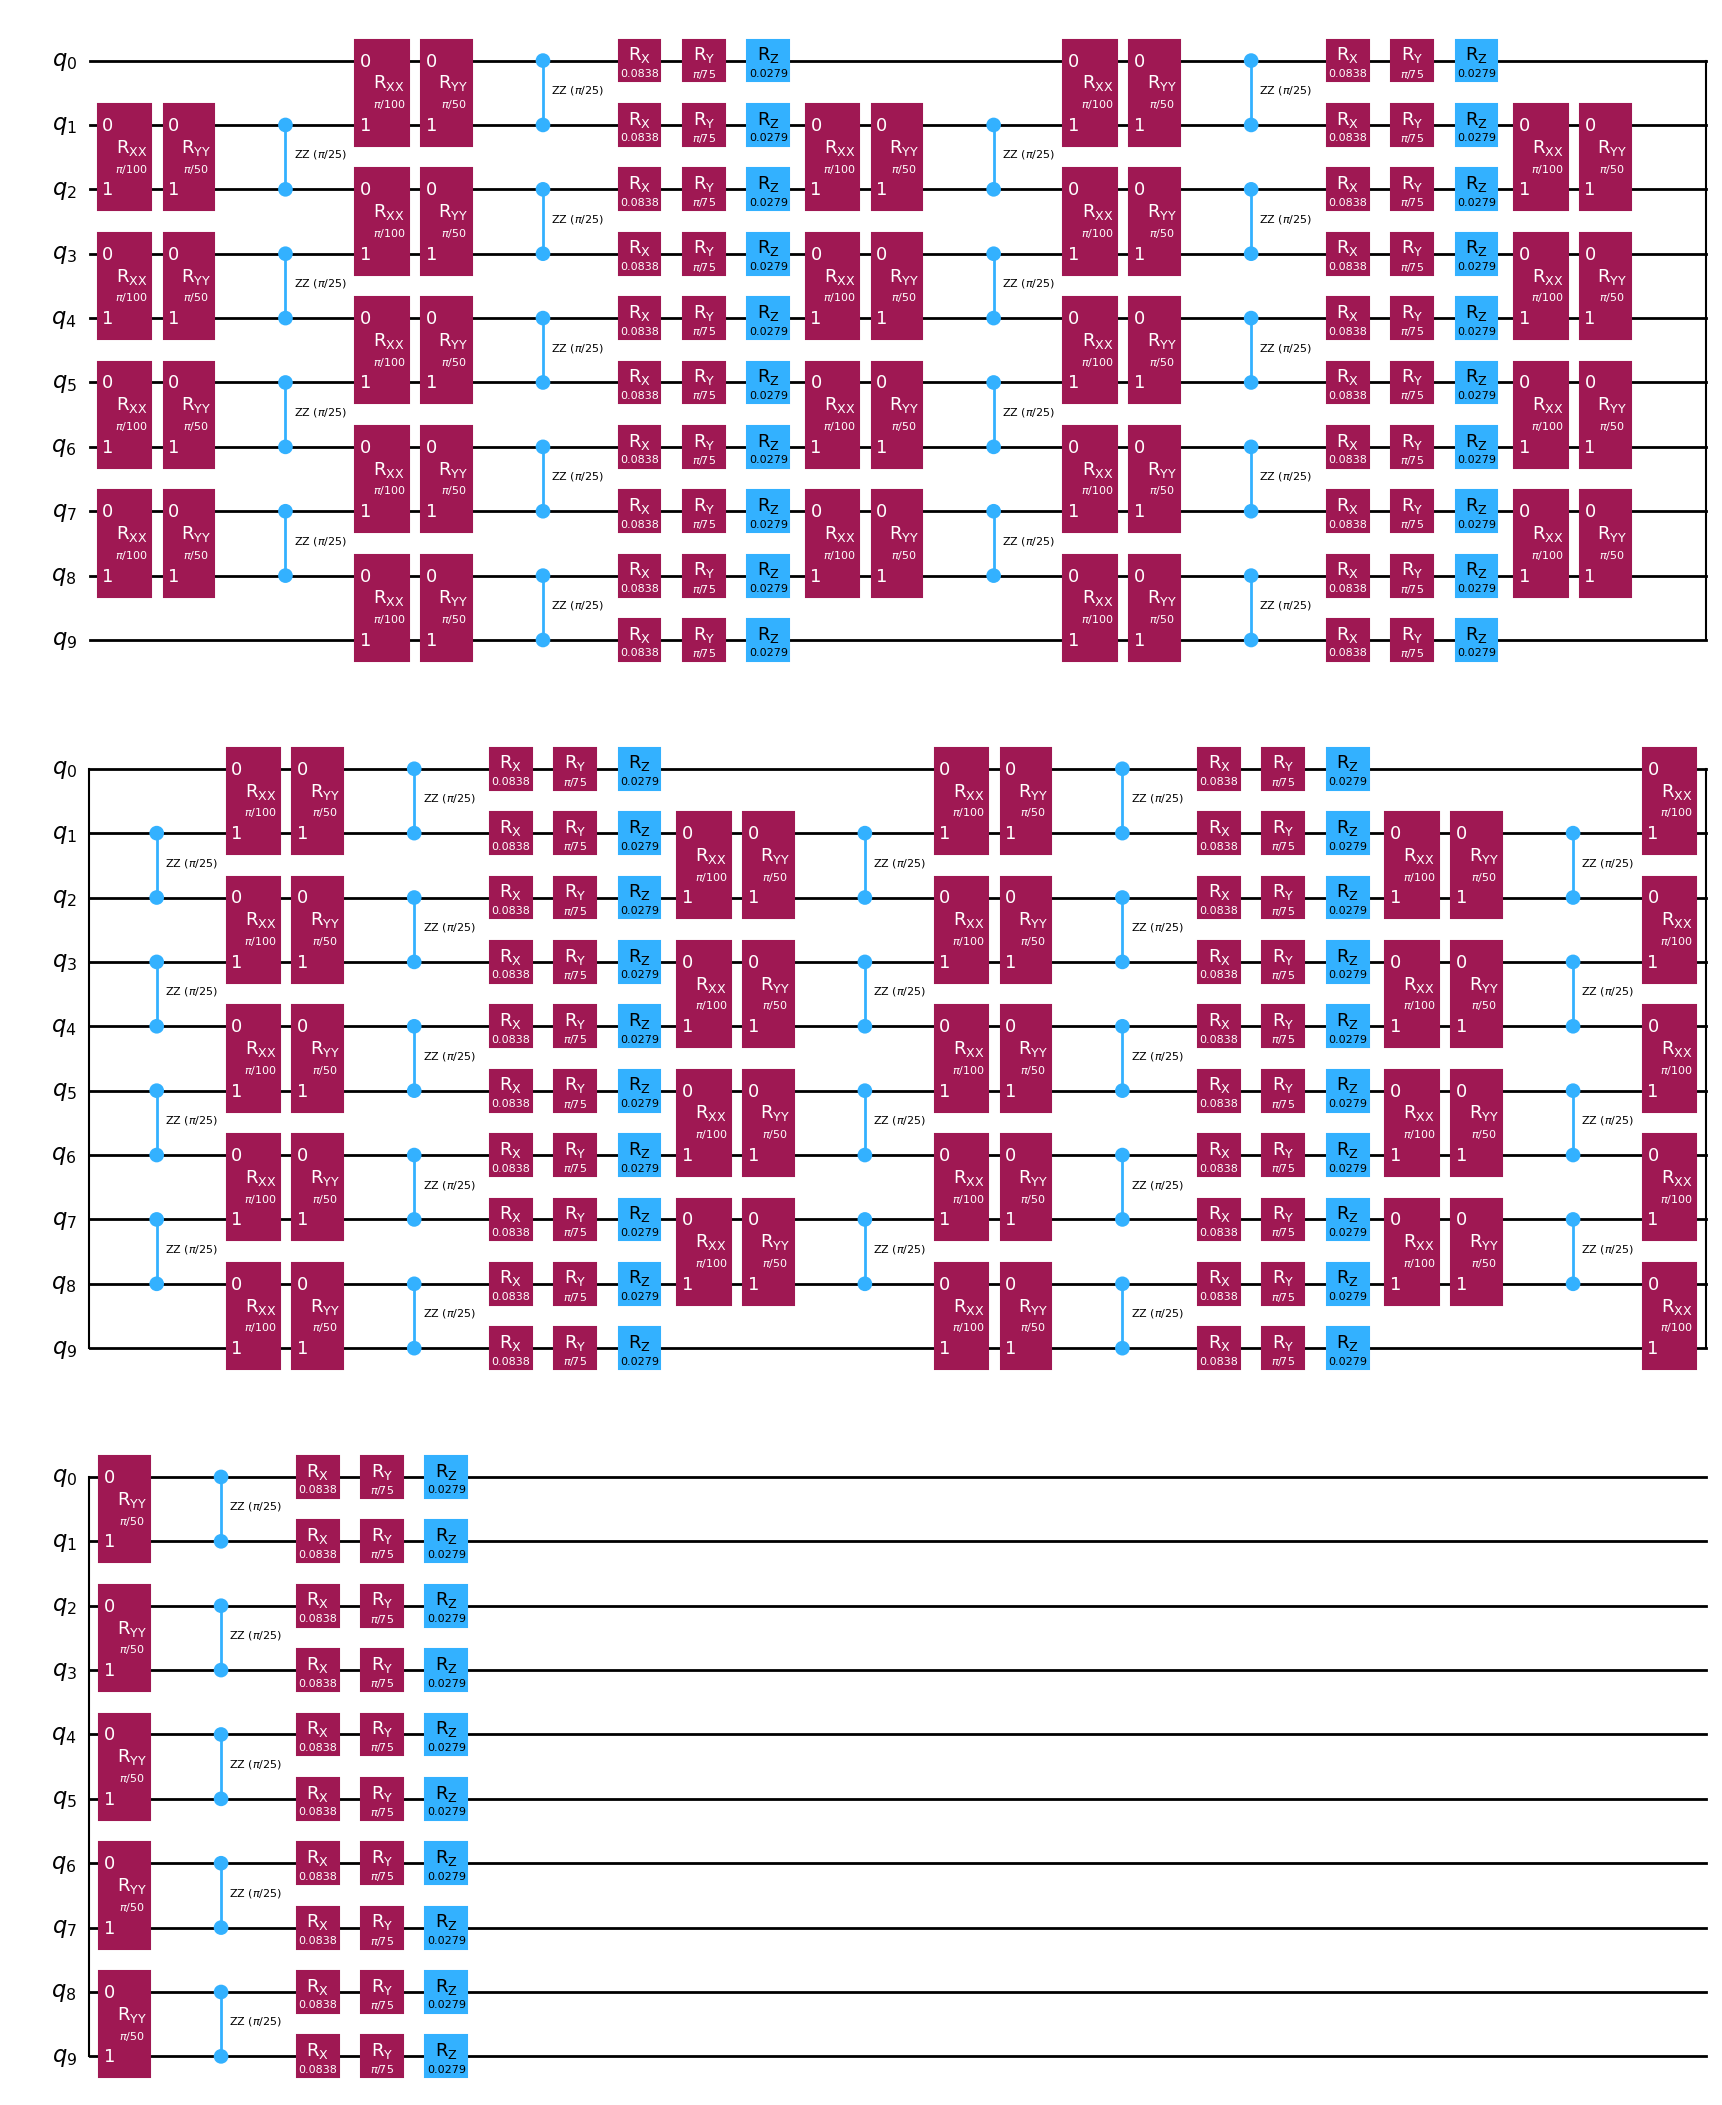

In [18]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, Batch
from qiskit_ibm_runtime.fake_provider import FakeMelbourneV2, FakeKolkataV2
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_addon_utils.problem_generators import (
    generate_time_evolution_circuit,
    generate_xyz_hamiltonian,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, slice_by_depth
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices


coupling_map = CouplingMap.from_heavy_hex(3, bidirectional=False)

# Choose a 10-qubit linear chain on this coupling map
reduced_coupling_map = coupling_map.reduce(
    [0, 13, 1, 14, 10, 16, 5, 12, 8, 18]
)

# Get a qubit operator describing the Heisenberg XYZ model
hamiltonian = generate_xyz_hamiltonian(
    reduced_coupling_map,
    coupling_constants=(np.pi / 8, np.pi / 4, np.pi / 2),
    ext_magnetic_field=(np.pi / 3, np.pi / 6, np.pi / 9),
)

# we evolve for some time
circuit = generate_time_evolution_circuit(
    hamiltonian, synthesis=LieTrotter(reps=5), time=0.2
)

circuit.draw("mpl")

### Define Observable

In [19]:
# Specify a single-qubit observable
n=circuit.num_qubits
observable_terms = [
            "I"*(i-1) + "Z" + "I"*(n - i)
            for i in range(1, n+1)
        ]
observable = SparsePauliOp(observable_terms, coeffs=[1/(n)] * (n))
print(observable)

SparsePauliOp(['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIZIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'],
              coeffs=[0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j,
 0.1+0.j, 0.1+0.j])


### Define Backend

In [20]:
# service=QiskitRuntimeService(channel="ibm_cloud",token="n2Om3bZ5WlEvUWi6-Sudcxj5T_-vy3Ynj8-RrHnNU2Ca")
# backend = service.least_busy(operational=True, simulator=False)
# backend
backend=FakeKolkataV2()

In [21]:
truncation_error_budget_list = [] # The list of errors to be used 
max_error_per_slice_list = np.linspace(0.0001,0.04,20)
for error in max_error_per_slice_list:
    trunc_budget = setup_budget(max_error_per_slice=error)
    truncation_error_budget_list.append(trunc_budget)
print(truncation_error_budget_list)

[TruncationErrorBudget(per_slice_budget=[np.float64(0.0001)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0021999999999999997)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0043)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0064)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.008499999999999999)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.010599999999999998)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0127)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.014799999999999999)], max_error_total=inf, p_norm=1, tol=1e-08), TruncationErrorBudget(per_slice_budget=[np.float64(0.0169)], max_error_total=inf, p_norm=1, tol=1e-08), Trunca

In [22]:
truncation_error_budget_list[:13]

[TruncationErrorBudget(per_slice_budget=[np.float64(0.0001)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.0021999999999999997)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.0043)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.0064)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.008499999999999999)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.010599999999999998)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.0127)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.014799999999999999)], max_error_total=inf, p_norm=1, tol=1e-08),
 TruncationErrorBudget(per_slice_budget=[np.float64(0.0169)], max_error_total=inf, p_norm=1, tol=1e-08)

In [23]:
pm = generate_preset_pass_manager(basis_gates=backend.configuration().basis_gates, optimization_level=3, seed_transpiler=1)

### Synthesize circ0, the original experiment (Synthesized circuit with no OBP)

In [24]:
circ0 = pm.run(circuit)
print(" The depth of the circuit with no OBP is : ",circ0.depth() )

 The depth of the circuit with no OBP is :  101


In [25]:
# Define an operator budget
op_budget = OperatorBudget(max_qwc_groups=8)

# Slice the isa_circuit by depth
synthesized_slices = slice_by_depth(circ0, max_slice_depth=1)
print(f"Slice_by_depth separated the circuit into {len(synthesized_slices)} slices.")

Slice_by_depth separated the circuit into 101 slices.


### Define circ1, the backpropagated circuit with no truncation

In [26]:
# Backpropagate without the truncation error budget
backpropagated_observable, remaining_slices, metadata = backpropagate(
    observable,
    synthesized_slices,
    operator_budget=op_budget,
)
# Recombine the slices remaining after backpropagation
circ1 = combine_slices(remaining_slices, include_barriers=False)

print(f"Depth of the backpropagated circuit with no truncation is: ", circ1.depth())

Depth of the backpropagated circuit with no truncation is:  87


In [9]:
#backpropagated_observable.group_commuting()

### Define circ2 to circ20

In [28]:
truncated_circs = []
truncated_observables=[]
# Backpropagate *with* the truncation error budget
for err in truncation_error_budget_list[:6]:
    backpropagated_observable_trunc, remaining_slices_trunc, metadata_trunc = backpropagate(
            observable,
            synthesized_slices,
            operator_budget=op_budget,
            truncation_error_budget=err,
        )

# Recombine the slices remaining after backpropagation
    bp_circuit_trunc = combine_slices(
        remaining_slices_trunc, include_barriers=False
    )
    if bp_circuit_trunc != None:
        truncated_circs.append(bp_circuit_trunc)
    else:
        bp_circuit_trunc =QuantumCircuit(circuit.num_qubits)
        truncated_circs.append(bp_circuit_trunc)
    truncated_observables.append(backpropagated_observable_trunc) # truncated observables appended
print(truncated_circs)
    #bp_circuit_trunc.draw("mpl")
#print(truncated_observables)




for truncated_circ in truncated_circs:
    if truncated_circ != None:
        print(f"Depth of the truncated backpropagated circuit is: ", truncated_circ.depth())
    else:
        print(f"Depth of the truncated backpropagated circuit is: ", 0)



[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x155530b60>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x15568d490>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1556ce7e0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x1552f8d10>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x156dc40e0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x155e8ac90>]
Depth of the truncated backpropagated circuit is:  87
Depth of the truncated backpropagated circuit is:  74
Depth of the truncated backpropagated circuit is:  65
Depth of the truncated backpropagated circuit is:  74
Depth of the truncated backpropagated circuit is:  25
Depth of the truncated backpropagated circuit is:  0


In [29]:
truncated_circs_isa=[]
observable_truncated_circs_isa =[]
truncated_circuit_depths = []
pass_manager =generate_preset_pass_manager(optimization_level=3, backend=backend, seed_transpiler=1)

circ0_isa =pass_manager.run(circ0)
observable_isa_circ0 = observable.apply_layout(circ0_isa.layout)
truncated_circuit_depths.append(circ0_isa.depth())
circ1_isa =pass_manager.run(circ1)
observable_isa_circ1 = backpropagated_observable.apply_layout(circ1_isa.layout)
truncated_circuit_depths.append(circ1_isa.depth())
for ckt,trunc_obs in zip(truncated_circs,truncated_observables):
        truncated_circ_isa = pass_manager.run(ckt)
        observable_isa_trunc_circ = trunc_obs.apply_layout(truncated_circ_isa.layout)
        truncated_circs_isa.append(truncated_circ_isa)
        observable_truncated_circs_isa.append(observable_isa_trunc_circ)

for truncated_ckt in truncated_circs_isa:
    if truncated_ckt != None:
        depth = truncated_ckt.depth()
        truncated_circuit_depths.append(depth)
    else:
        truncated_circuit_depths.append(0)

print(truncated_circuit_depths)



[101, 87, 87, 74, 65, 74, 25, 0]


In [30]:
estimator_ideal = EstimatorV2(mode=AerSimulator())
result_ideal =(
    estimator_ideal.run([(circ0_isa, observable_isa_circ0)]).result()[0].data.evs.item()
)
print("The ideal expectation value is : ", result_ideal)

The ideal expectation value is :  0.893017578125


In [31]:
job =[]
with Batch(backend=AerSimulator()) as batch:
    estimator=EstimatorV2(mode=AerSimulator())
    pub0 = (circ0_isa,observable_isa_circ0)
    job0=estimator.run([pub0,pub0,pub0,pub0,pub0])
    job.append(job0)

    pub1 = (circ1_isa,observable_isa_circ1)
    job1=estimator.run([pub1,pub1,pub1,pub1,pub1])
    job.append(job1)

    for circ_err,obs_err in zip(truncated_circs_isa, observable_truncated_circs_isa):
        puberr= (circ_err,obs_err)
        job_err = estimator.run([puberr,puberr,puberr,puberr,puberr])
        job.append(job_err)


base_primitive._run:WARNING:2025-06-12 21:34:15,467: Even though a session/batch context manager is open this job will run in job mode because the estimator primitive was initialized outside the context manager. Move the estimator initialization inside the context manager to run in a session/batch.
base_primitive._run:WARNING:2025-06-12 21:34:15,508: Even though a session/batch context manager is open this job will run in job mode because the estimator primitive was initialized outside the context manager. Move the estimator initialization inside the context manager to run in a session/batch.
base_primitive._run:WARNING:2025-06-12 21:34:15,566: Even though a session/batch context manager is open this job will run in job mode because the estimator primitive was initialized outside the context manager. Move the estimator initialization inside the context manager to run in a session/batch.
base_primitive._run:WARNING:2025-06-12 21:34:15,698: Even though a session/batch context manager is 

In [32]:
batch_id = batch.session_id
print(batch_id)

None


In [33]:
batch.status()

In [34]:
job[0].result()[0].data.evs.item()

0.89541015625

In [35]:
exp_vals = []
for j in job:
    exp_vals.append((j.result()[0].data.evs.item(),
                      j.result()[1].data.evs.item(),
                      j.result()[2].data.evs.item(),
                      j.result()[3].data.evs.item(),
                      j.result()[4].data.evs.item()))
print(exp_vals)

[(0.89541015625, 0.8955078125, 0.8927246093750001, 0.89033203125, 0.891845703125), (0.8922948151068955, 0.8929272145078674, 0.8934956054598565, 0.8936533577756758, 0.8960556583675), (0.8923487479723888, 0.8929591328695112, 0.8967801847750372, 0.8909449544856919, 0.8945029092559537), (0.8898067802326173, 0.8895151043486945, 0.8891127672918349, 0.8933949210445686, 0.8892392731800969), (0.881273088550281, 0.8833892849738604, 0.8836788921616197, 0.8827442339498642, 0.8840558996787171), (0.8835342445329823, 0.8852856653905234, 0.8862834144158557, 0.8873369879205258, 0.8855205756005795), (0.9016156385211419, 0.8994659133429346, 0.9015615412316574, 0.8994667889599769, 0.8963716777781855), (0.8997861476737384, 0.8943718921969154, 0.8991712354154121, 0.8982808069367696, 0.8985553273337641)]


/var/folders/tn/sxmbbhqd03lc2zx_q4nzlqrw0000gn/T/ipykernel_12557/159525689.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90, fontsize=15)


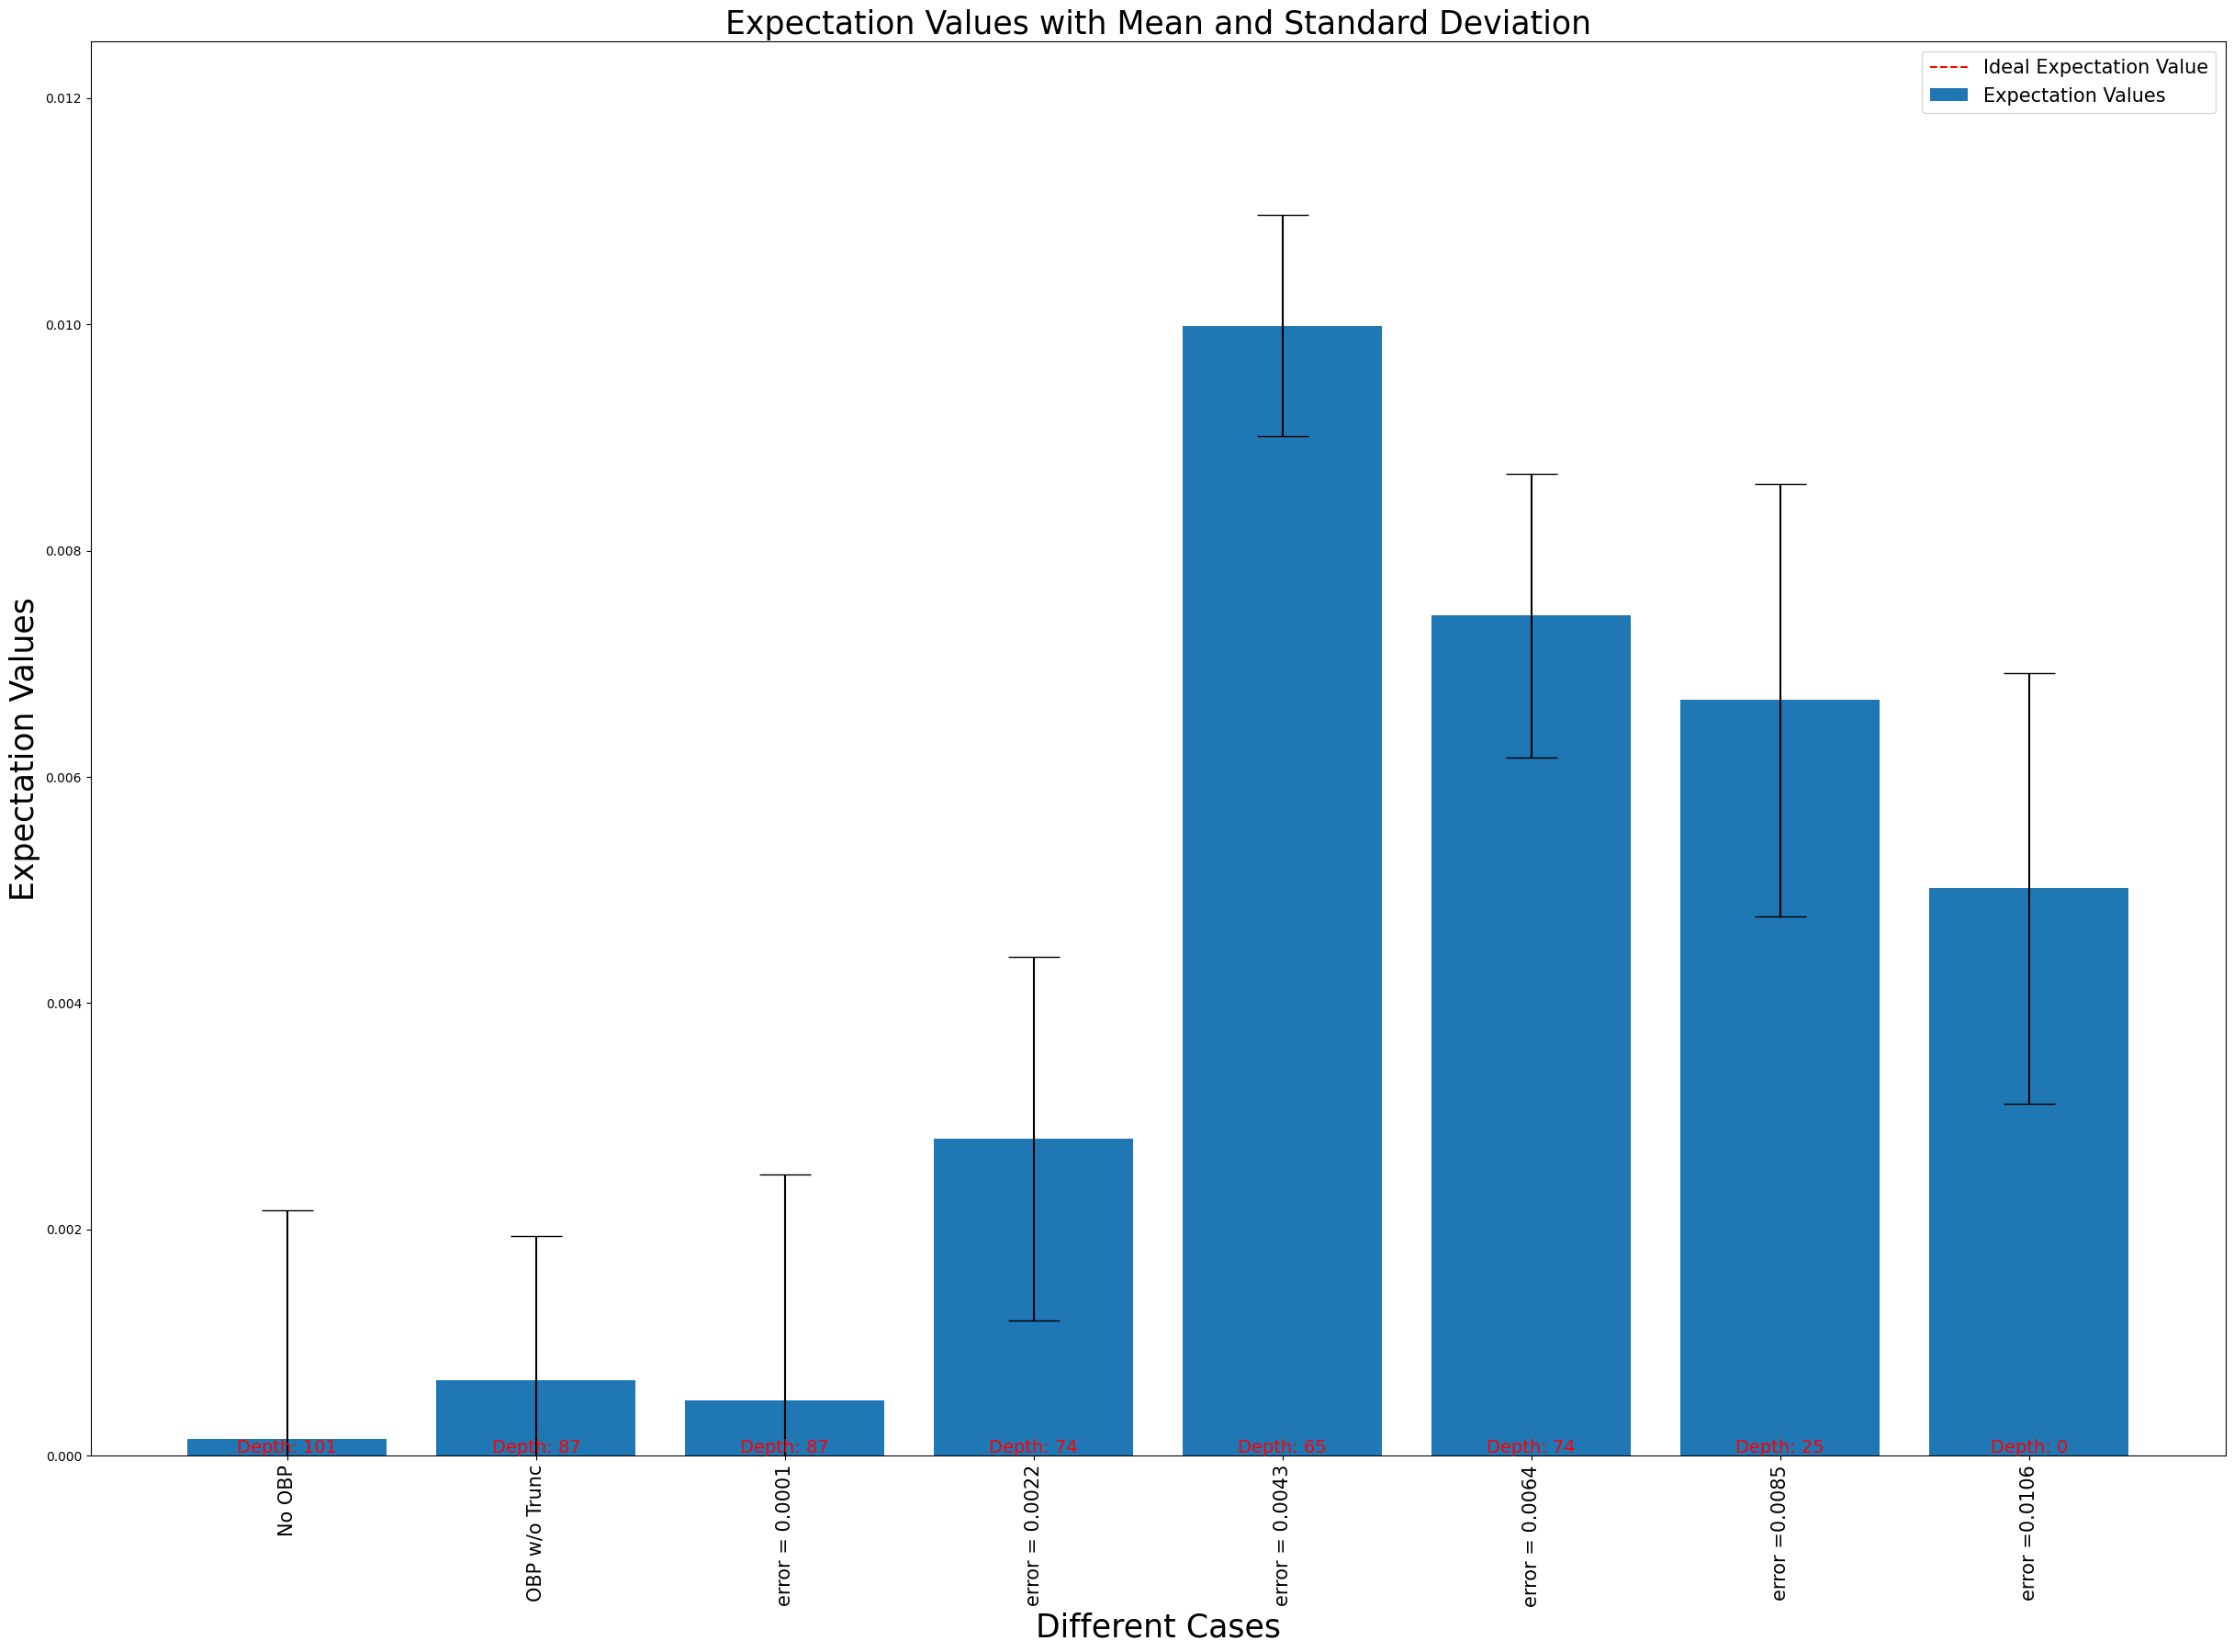

In [58]:
import matplotlib.pyplot as plt
import numpy as np

means = [abs(result_ideal-np.mean(t)) for t in exp_vals]
std_devs = [np.std(t) for t in exp_vals]
#print(means)

bar_lengths = means
error_bars = std_devs

#x_pos = np.arange(1, 23)
fig, ax = plt.subplots(figsize=(30,20))
labels=['No OBP','No OBP', 'OBP w/o Trunc', 'error = 0.0001', 'error = 0.0022','error = 0.0043', 'error = 0.0064', 'error =0.0085', 'error =0.0106']
ax.set_xticklabels(labels, rotation=90, fontsize=15)

x_pos = range(8)  # same length as your data
ax.bar(x_pos, bar_lengths, yerr=error_bars, capsize=20, label='Expectation Values')
for i, depth in enumerate(truncated_circuit_depths):
    ax.text(x_pos[i], 0.00015, f'Depth: {int(depth)}', ha='center', va='top', fontsize=14, color='red')
ax.set_xlabel("Different Cases", fontsize=25)
ax.set_ylabel("Expectation Values", fontsize=25)
ax.set_title("Expectation Values with Mean and Standard Deviation", fontsize=25)
# Adjust plot limits to avoid cutting off text
ax.set_ylim([0.0, 0.0125])
plt.axhline(y=result_ideal, color='r', linestyle='--', label='Ideal Expectation Value')
plt.legend(fontsize=15)
plt.show()
